<a href="https://colab.research.google.com/github/Gonkalos/AA2-Embeddings/blob/main/Seq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importes gerais / Instalações

In [5]:
% matplotlib inline
!pip install kora
clear_output()


import pandas as pd
import seaborn as sns
import numpy as np
import requests
import io
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output 
import kora.install.rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, Descriptors
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

#Get dataset from repository 
- Using original dataset instead of lastest review

In [6]:
url = 'https://github.com/GLambard/Molecules_Dataset_Collection/raw/master/originals/HIV.csv'

data = requests.get(url).content
df = pd.read_csv(io.StringIO(data.decode('utf-8')), index_col = 0)
df.reset_index(inplace=True)
df

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0
...,...,...,...
41122,CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...,CI,0
41123,Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...,CI,0
41124,Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...,CI,0
41125,Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...,CI,0



# Seq2Seq Fingerprint
> informações utilizadas
> - https://github.com/XericZephyr/seq2seq-fingerprint/
> - https://www.cheminformania.com/master-your-molecule-generator-seq2seq-rnn-models-with-smiles-in-keras/

Seguimento do seguinte post: [**Master your molecule generator: Seq2seq RNN models with SMILES in Keras** ](https://www.cheminformania.com/master-your-molecule-generator-seq2seq-rnn-models-with-smiles-in-keras/)

In [7]:
# General Imports
%matplotlib inline
data = df

from sklearn.model_selection import train_test_split

smiles_train, smiles_test = train_test_split(data["smiles"], random_state=42)
print(smiles_train.shape)
print(smiles_test.shape)
print(df.fillna('').astype(str).apply(lambda x:x.str.len()).mean())

(30845,)
(10282,)
smiles        45.342451
activity       2.000000
HIV_active     1.000000
dtype: float64


É necessário vectorizar os *SMILES* para um array.
para isto, um conjunto de caracteres é construido a partir de todos os caracteres encontrados nos *SMILES* (os de teste e de treino). 
Além disso, alguns caracteres são adicionaidos ao inicio e fim de cada *SMILE* para sinalizar quando a começou e acabou


*The stop character also work as padding to get the same length of all vectors, so that the network can be trained in batch mode. The character set is used to define two dictionaries to translate back and forth between index and character. The maximum length of the SMILES strings is needed as the RNN’s will be trained in batch mode, and is set to the maximum encountered + some extra.*

<!---The SMILES must be vectorized to one-hot encoded arrays. To do this a character set is built from all characters found in the SMILES string (both train and test). Also, some start and stop characters are added, which will be used to initiate the decoder and to signal when SMILES generation has stopped. The stop character also work as padding to get the same length of all vectors, so that the network can be trained in batch mode. The character set is used to define two dictionaries to translate back and forth between index and character. The maximum length of the SMILES strings is needed as the RNN’s will be trained in batch mode, and is set to the maximum encountered + some extra.-->

In [ ]:
charset = set("".join(list(data.smiles))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
embed = max([len(smile) for smile in data.smiles]) + 5
print(str(charset))
print(len(charset), embed)

{'0', 'T', 'S', 's', '!', '.', 'i', 'd', 'p', 'a', '6', 'c', '[', 'K', 'C', 'l', 'e', '+', 'V', ']', 'o', 'h', '4', 'R', '5', 'U', 'N', 'F', '%', 'L', '-', '2', 'u', '=', 'P', 'n', 'O', '3', 'r', 'M', 'A', '8', '7', 'G', '#', '9', '1', 'b', 'g', ')', 't', 'I', 'B', 'Z', 'W', '(', 'E', 'H'}
58 585


*Afterwards the character set and dictionaries are used to set the necessary bits in the Numpy arrays. The result will be a “piano-roll” of each molecules SMILES string. The X data starts with !, but the output Y is offset by one character, and starts with the first character of the actual SMILES.*


Oc1nc2ccccc2c2oc3ccccc3c12
(30845, 584, 58)


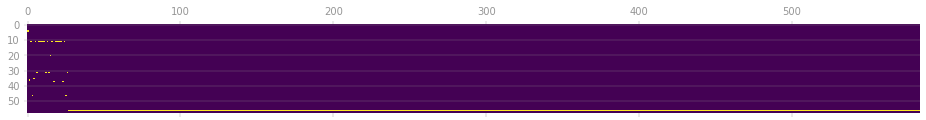

In [ ]:
def vectorize(smiles):
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,0:-1,:], one_hot[:,1:,:]
X_train, Y_train = vectorize(smiles_train.values)
X_test,Y_test = vectorize(smiles_test.values)
print(smiles_train.iloc[0])
plt.matshow(X_train[0].T)
print(X_train.shape)

In [ ]:
!pip install perfplot
clear_output()
import perfplot
perfplot.save(
    "out.png",
    setup=lambda n: pd.DataFrame(np.arange(n * 3).reshape(n, 3)),
    n_range=[2**k for k in range(25)],
    kernels=[
        lambda df: len(df.index),
        lambda df: df.shape[0],
        lambda df: df[df.columns[0]].count(),
    ],
    labels=["len(df.index)", "df.shape[0]", "df[df.columns[0]].count()"],
    xlabel="Number of rows",
)


Output()

In [ ]:
"".join([int_to_char[idx] for idx in np.argmax(X_train[0,:,:], axis=1)])

'!Oc1nc2ccccc2c2oc3ccccc3c12EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE'

In [ ]:
#Import Keras objects
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Concatenate 
from keras import regularizers
input_shape = X_train.shape[1:]
output_dim = Y_train.shape[-1]
latent_dim = 64
lstm_dim = 64

In [ ]:
unroll = False
encoder_inputs = Input(shape=input_shape)
encoder = LSTM(lstm_dim, return_state=True,unroll=unroll)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
states = Concatenate(axis=-1)([state_h, state_c])
neck = Dense(latent_dim, activation="relu")
neck_outputs = neck(states)

In [ ]:
decode_h = Dense(lstm_dim, activation="relu")
decode_c = Dense(lstm_dim, activation="relu")
state_h_decoded =  decode_h(neck_outputs)
state_c_decoded =  decode_c(neck_outputs)
encoder_states = [state_h_decoded, state_c_decoded]
decoder_inputs = Input(shape=input_shape)
decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,unroll=unroll)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(output_dim, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
#Define the model, that inputs the training vector for two places, and predicts one character ahead of the input
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
print (model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 584, 58)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 64), (None,  31488       input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128)          0           lstm[0][1]                       
                                                                 lstm[0][2]                       
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           8256        concatenate[0][0]            

In [ ]:
from keras.callbacks import History, ReduceLROnPlateau
h = History()
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, epsilon=1e-5)
from keras.optimizers import RMSprop, Adam
opt=Adam(lr=0.005) #Default 0.001
model.compile(optimizer=opt, loss='categorical_crossentropy')
model.fit([X_train,X_train],Y_train,
                    epochs=200,
                    batch_size=256,
                    shuffle=True,
                    callbacks=[h, rlr],
                    validation_data=[[X_test,X_test],Y_test ])

Epoch 1/200
121/121 [==============================] - ETA: 0s - loss: 0.8832

ValueError: ignored

In [ ]:
import pickle
pickle.dump(h.history, file("Blog_history.pickle","w"))

In [ ]:
plt.plot(h.history["loss"], label="Loss")
plt.plot(h.history["val_loss"], label="Val_Loss")
plt.yscale("log")
plt.legend()